In [1]:
import numpy as np
from dataclasses import dataclass

import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
@dataclass
class Cell():
    alive: bool = False

    def set(self,state):
        self.alive = state

    def get(self):
        return self.alive
    
class Lattice():
    def __init__(self,size: int):
        self.size = size
        self.grid = np.array([[Cell() for i in range(self.size)] for j in range(self.size)])

    def set_state(self, idx: list[tuple[int,int]], state: bool):
        row_idx = [row for row, _ in idx]
        col_idx = [col for _, col in idx]

        for cell in self.grid[row_idx,col_idx]:
            cell.set(state)


    def get_states(self, grid = None):
        if grid is not None:
            return np.array([[cell.get() for cell in row] for row in grid])
        else:
            return np.array([[cell.get() for cell in row] for row in self.grid])
    
    def plot(self, ax = None):
        data_ = self.get_states()
        if ax is not None:
            self.img = sns.heatmap(data_,cbar=False,linewidths=0.1,xticklabels=False,yticklabels=False,cmap='rocket_r',ax = ax)
        else:
            self.img = sns.heatmap(data_,cbar=False,linewidths=0.1,xticklabels=False,yticklabels=False,cmap='rocket_r')
        

    # def animate(self, frame):
    #     self.update()
    #     self.img.set_data(self.get_states())
    #     return [self.img]
        

    def update(self):
        # bottom
        bottom = self.get_states(np.roll(self.grid,-1,axis=0)).astype(int)
        # up
        up = self.get_states(np.roll(self.grid,1,axis=0)).astype(int)
        # right
        right = self.get_states(np.roll(self.grid,-1,axis=1)).astype(int)
        # left 
        left = self.get_states(np.roll(self.grid,1,axis=1)).astype(int)
        # upper right
        upper_right = self.get_states(np.roll(np.roll(self.grid,-1,axis=1),1,axis=0)).astype(int)
        # upper left
        upper_left = self.get_states(np.roll(np.roll(self.grid,1,axis=1),1,axis=0)).astype(int)
        # bottom right
        bottom_right = self.get_states(np.roll(np.roll(self.grid,-1,axis=1),-1,axis=0)).astype(int)
        # bottom left
        bottom_left = self.get_states(np.roll(np.roll(self.grid,1,axis=1),-1,axis=0)).astype(int)

        live_or_die = bottom + up + right + left + upper_left + upper_right + bottom_left + bottom_right # number of live nbrs

        # update according to Conway's Game of Life
        # conditions for live cells
        underpopulation = np.where( (live_or_die < 2) & (self.get_states() == True) ) # dies
        overpopulation = np.where( (live_or_die > 3) & (self.get_states() == True) ) # dies
        stable = np.where( ( (live_or_die == 2) | (live_or_die == 3) ) & (self.get_states() == True) ) # lives

        # conditions for dead cells
        reborn = np.where((live_or_die == 3) & (self.get_states() == False)) # lives

        # update
        for cell in self.grid[*underpopulation]:
            cell.set(False)

        for cell in self.grid[*overpopulation]:
            cell.set(False)

        for cell in self.grid[*stable]:
            cell.set(True)

        for cell in self.grid[*reborn]:
            cell.set(True)


        


* Any live cell with fewer than two live neighbours dies, as if by underpopulation.

* Any live cell with two or three live neighbours lives on to the next generation.

* Any live cell with more than three live neighbours dies, as if by overpopulation.

* Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction

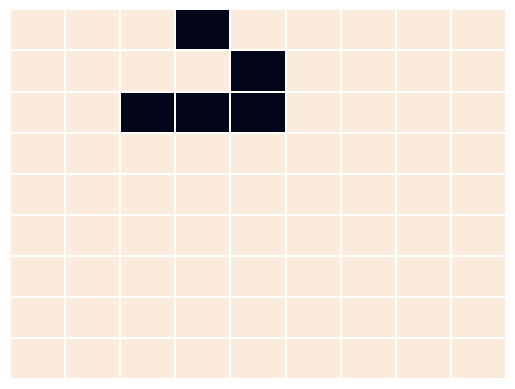

In [14]:
N = 9
lattice = Lattice(N)

blinker = [(2,1), (2,2), (2,3)]

glider = [(2,2), (2,3),(2,4),(1,4),(0,3)]


lattice.set_state(glider,True)

fig, ax = plt.subplots()

lattice.plot()


**HECS = Hexagonal Efficient Coordinate System**

parametrisation of hexagonal lattice:

* parametrisation by two arrays

* array 0 parametrises all even rows of lattice

* array 1 parametrises all odd rows of lattice 

* each hexagon uniquely identified by triple $(a,r,c) \in \{0,1\} \times \mathbb{Z} \times \mathbb{Z}$ where $a$ indexes array, $r,c$ row and coloumns

* there is a linear transformation from $T \colon \{0,1\} \times \mathbb{Z} \times \mathbb{Z} \to \mathbb{R}^2$ sending a triple $(a,r,c) \mapsto (x,y)$ to the center of the corresponding hexagon

In [2]:
size = 2

T = np.sqrt(3)*size*np.array([[0.5,0,1],[0.5*np.sqrt(3), np.sqrt(3),0]]) 

def HECS_to_Cartesian(p:np.ndarray):
   assert p.shape == (3,1), f"expected shape (3,1), got {p.shape}"

   return tuple((T @ p).flatten())

def create_hexagon(center:tuple[float,float],size):
    i,j = center 
    
    vertices = [
        (i, j + size), 
        (i - 0.5 * np.sqrt(3)*size, j + 0.5*size), 
        (i - 0.5 * np.sqrt(3)*size, j - 0.5*size), 
        (i, j - size), 
        (i + 0.5 * np.sqrt(3)*size, j - 0.5*size), 
        (i + 0.5 * np.sqrt(3)*size, j + 0.5*size), 
        ]
    return vertices

def get_neighbours(hexagon: tuple[int,int,int]):
    a,r,c = hexagon

    right = (a, r, c + 1)
    right_above = (1 - a, r - (1 - a), c + a)
    left_above = (1 - a, r - (1 - a), c - (1 - a))
    left = (a, r, c - 1)
    left_below = (1 - a, r + a, c - (1 - a))
    right_below = (1 - a, r + a, c + a)

    return (right, right_above, left_above, left, left_below, right_below)


        

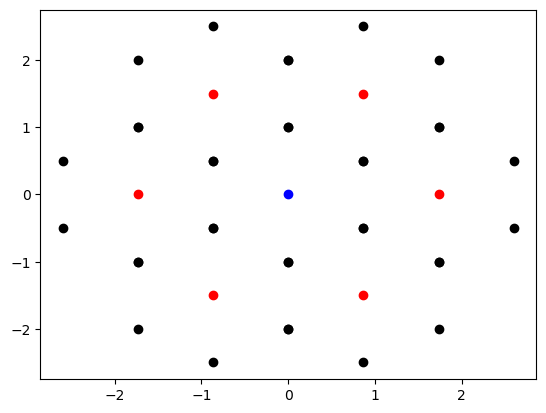

In [80]:
# TESTING get_neighbours
center0 = (0,0)
centers = []
nbrs = get_neighbours((0,0,0))

for nbr in nbrs:
    centers.append(HECS_to_Cartesian( np.array(nbr).reshape(-1,1)) )

fig, ax  = plt.subplots()

ax.scatter(*center0,color='blue')

for center in centers:
    vertices = create_hexagon(center)
    ax.scatter(*center,color='red')

    for x,y in vertices:
        ax.scatter(x,y,color='k')



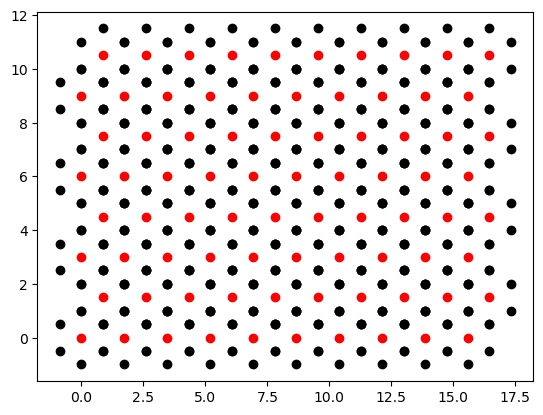

In [92]:
# TESTING HECS 
ROWS = 4
COLS = 10
even_rows = np.array([ [(0,r,c) for c  in range(COLS)] for r in range(ROWS)])
odd_rows = np.array([ [(1,r,c) for c  in range(COLS)] for r in range(ROWS)])

centers = []

for a in [even_rows,odd_rows]:
    for row in a:
        for c in row:
            centers.append(HECS_to_Cartesian(c.reshape(-1,1)))

fig, ax  = plt.subplots()

for center in centers:
    vertices = create_hexagon(center)
    ax.scatter(*center,color='red')

    for x,y in vertices:
        ax.scatter(x,y,color='k')


In [16]:
centers = [(0,0)]
vertices = []
for center in centers:
    vertices.extend(create_hexagon(center))

vertices

[(0, 1),
 (-0.8660254037844386, 0.5),
 (-0.8660254037844386, -0.5),
 (0, -1),
 (0.8660254037844386, -0.5),
 (0.8660254037844386, 0.5)]

In [17]:
list(sum(vertices, ()))

[0,
 1,
 -0.8660254037844386,
 0.5,
 -0.8660254037844386,
 -0.5,
 0,
 -1,
 0.8660254037844386,
 -0.5,
 0.8660254037844386,
 0.5]